In [8]:
# Use the '!' to run shell commands directly from the notebook cell
!pip install geopandas earthengine-api requests rasterio rasterstats scikit-learn pandas matplotlib statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import geopandas as gpd
import ee
import requests
import os
import zipfile

# This will trigger the authentication flow in your browser.
ee.Authenticate()

# Initialize the library for this session.
ee.Initialize()

print("🌍 Google Earth Engine Initialized Successfully!")

🌍 Google Earth Engine Initialized Successfully!


In [11]:
# The path to your data file in the project folder
gpkg_path = '5th cite.gpkg'

print("Defining Area of Interest from ward boundaries...")

# Load the wards layer using GeoPandas
wards_gdf = gpd.read_file(gpkg_path, layer='wards_2022')

# Step 1: Reproject the data to the required WGS84 coordinate system.
wards_gdf = wards_gdf.to_crs("EPSG:4326")
print(f"  - Step 1: Reprojected data to WGS84 (EPSG:4326).")

# Step 2: Calculate the total bounding box of all wards.
bounds = wards_gdf.total_bounds
print(f"  - Step 2: Calculated total bounds: {bounds}")

# Step 3: Create a new, simple ee.Geometry.Rectangle from the bounds.
aoi = ee.Geometry.Rectangle(*bounds)

print("\n✅ AOI defined successfully using a robust bounding box.")

Defining Area of Interest from ward boundaries...
  - Step 1: Reprojected data to WGS84 (EPSG:4326).
  - Step 2: Calculated total bounds: [77.4598797 12.8334905 77.7843613 13.1426195]

✅ AOI defined successfully using a robust bounding box.


In [12]:
print("Preparing high-resolution data for download...")

# 1. Topography: Digital Elevation Model (DEM) and Slope
dem = ee.Image('USGS/SRTMGL1_003').clip(aoi)
slope = ee.Terrain.slope(dem)
print("  - DEM and Slope prepared.")

# 2. Surface: Recent Land Use / Land Cover (LULC)
lulc_recent = ee.ImageCollection('MODIS/061/MCD12Q1').sort('system:time_start', False).first().select('LC_Type1').clip(aoi)
print("  - Most recent LULC prepared.")

# --- Download and Verify Files ---
download_dir = 'Flood_Prediction_Data_Local'
os.makedirs(download_dir, exist_ok=True)

def download_image(image, filename, scale, directory, aoi_geom):
    path = os.path.join(directory, filename)
    try:
        url = image.getDownloadURL({'scale': scale, 'crs': 'EPSG:4326', 'region': aoi_geom})
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()
        with open(path, 'wb') as f: f.write(response.content)
        if os.path.exists(path): print(f"✅ Successfully downloaded and verified: {path}\n")
        else: print(f"❌ DOWNLOAD FAILED: {path} was not created.\n")
    except Exception as e: print(f"❌ Failed to download {filename}. Reason: {e}\n")

download_image(dem, 'dem.zip', 30, download_dir, aoi)
download_image(slope, 'slope.zip', 30, download_dir, aoi)
download_image(lulc_recent, 'lulc_2023.zip', 500, download_dir, aoi)

Preparing high-resolution data for download...
  - DEM and Slope prepared.
  - Most recent LULC prepared.
✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\dem.zip

✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\dem.zip

✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\slope.zip

✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\slope.zip

✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\lulc_2023.zip

✅ Successfully downloaded and verified: Flood_Prediction_Data_Local\lulc_2023.zip



In [13]:
print("Unzipping files...")
zip_files_to_unzip = ['dem.zip', 'slope.zip', 'lulc_2023.zip']
tif_files_to_check = ['dem.tif', 'slope.tif', 'lulc_2023.tif']

for zip_file in zip_files_to_unzip:
    path_to_zip = os.path.join(download_dir, zip_file)
    if os.path.exists(path_to_zip):
        with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
            zip_ref.extractall(download_dir)
        print(f"  - Extracted: {zip_file}")

print("\n--- Verifying Extracted Files ---")
all_files_found = True
for tif_file in tif_files_to_check:
    path_to_tif = os.path.join(download_dir, tif_file)
    if os.path.exists(path_to_tif): print(f"✅ Found: {path_to_tif}")
    else:
        print(f"❌ MISSING: {path_to_tif}")
        all_files_found = False

if not all_files_found:
    print("\n❌ One or more .tif files are missing. Please re-run the download cell.")
else:
    print("\n✅ All necessary static files are present.")

Unzipping files...
  - Extracted: dem.zip
  - Extracted: slope.zip
  - Extracted: lulc_2023.zip

--- Verifying Extracted Files ---
✅ Found: Flood_Prediction_Data_Local\dem.tif
✅ Found: Flood_Prediction_Data_Local\slope.tif
✅ Found: Flood_Prediction_Data_Local\lulc_2023.tif

✅ All necessary static files are present.


In [14]:
import pandas as pd
import geopandas as gpd
from rasterstats import zonal_stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Load the Ward Boundaries again for analysis ---
wards = wards_gdf
print("Ward boundaries loaded successfully for analysis.")

# --- Define paths to your downloaded files ---
data_dir = 'Flood_Prediction_Data_Local'
dem_path = f'{data_dir}/dem.tif'
slope_path = f'{data_dir}/slope.tif'
lulc_path = f'{data_dir}/lulc_2023.tif'

# --- Inspect the available columns and set your ward identifier ---
print("\nAvailable columns in your wards data:")
print(wards.columns)

# !!! ACTION: Replace 'Name' with the correct column name from the list above !!!
ward_identifier_column = 'Name'

Ward boundaries loaded successfully for analysis.

Available columns in your wards data:
Index(['id', 'Name', 'description', 'timestamp', 'begin', 'end',
       'altitudeMode', 'tessellate', 'extrude', 'visibility', 'drawOrder',
       'icon', 'TownCode', 'WardCode', 'WardID', 'WardName', 'WardNo',
       'LGD_WardCode', 'OBJECTID', 'geometry'],
      dtype='object')


In [15]:
# --- Extract high-resolution features locally ---
print("\nExtracting high-resolution features (DEM, Slope, LULC)...")
wards['mean_elevation'] = pd.DataFrame(zonal_stats(wards, dem_path, stats="mean", nodata=-999))['mean']
wards['mean_slope'] = pd.DataFrame(zonal_stats(wards, slope_path, stats="mean", nodata=-999))['mean']
wards['land_cover'] = pd.DataFrame(zonal_stats(wards, lulc_path, stats="majority", nodata=-999))['majority']

# --- Perform robust, server-side TIME-SERIES rainfall extraction ---
print("\nRequesting server-side daily rainfall calculation for each ward...")

start_date = '2020-01-01'
end_date = '2024-12-31'
daily_collection = (
    ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
    .filterDate(start_date, end_date)
    .select('precipitation')
 )

# 2. Create a FeatureCollection of centroids with stable identifiers
projected_crs = wards.estimate_utm_crs()
wards_centroids = wards.to_crs(projected_crs).centroid.to_crs(wards.crs)
ee_features = []
for idx, geom in zip(wards.index, wards_centroids):
    geom_json = gpd.GeoSeries([geom]).__geo_interface__
    coords = geom_json['features'][0]['geometry']
    ee_feature = ee.Feature(ee.Geometry(coords), {'original_id': int(idx)})
    ee_features.append(ee_feature)
wards_ee_centroids = ee.FeatureCollection(ee_features)
print("  - Successfully created server-side FeatureCollection of ward centroids.")

# 3. Retrieve the daily rainfall time series for each ward
print("  - Downloading daily rainfall time series for each ward (this may take several minutes)...")
all_rainfall_rows = []
wards_list = wards_ee_centroids.toList(wards_ee_centroids.size())
num_wards = wards_ee_centroids.size().getInfo()

for i in range(num_wards):
    ward_feature = ee.Feature(wards_list.get(i))
    ward_info = ward_feature.getInfo()
    ward_id = ward_info['properties']['original_id']
    try:
        region_data = daily_collection.getRegion(
            geometry=ward_feature.geometry(),
            scale=5566
        ).getInfo()
    except Exception as e:
        print(f"    ❌ Failed to fetch data for ward {ward_id}: {e}")
        continue

    if len(region_data) <= 1:
        print(f"    ⚠️ No rainfall data for ward {ward_id}.")
        continue

    headers = region_data[0]
    data_rows = region_data[1:]
    ward_df = pd.DataFrame(data_rows, columns=headers)
    ward_df = ward_df[['time', 'precipitation']].dropna()
    if ward_df.empty:
        continue
    ward_df['date'] = pd.to_datetime(ward_df['time'], unit='ms').dt.date.astype(str)
    ward_df['rainfall'] = ward_df['precipitation'].astype(float)
    ward_df['original_id'] = ward_id
    all_rainfall_rows.append(ward_df[['original_id', 'date', 'rainfall']])

    if (i + 1) % 10 == 0:
        print(f"    ... processed {i + 1} of {num_wards} wards.")

if not all_rainfall_rows:
    raise RuntimeError("No rainfall data retrieved. Please verify the AOI and date range.")

rainfall_df_long = pd.concat(all_rainfall_rows, ignore_index=True)
rainfall_df_long = rainfall_df_long.drop_duplicates(subset=['original_id', 'date'])
rainfall_df = rainfall_df_long.pivot(index='original_id', columns='date', values='rainfall').sort_index(axis=1)
rainfall_df = rainfall_df.fillna(0)

# 5. Save the integrated data to a CSV file for offline use
csv_path = os.path.join(download_dir, 'ward_daily_rainfall.csv')
rainfall_df.to_csv(csv_path)
print(f"\n✅ Successfully processed and saved all rainfall data to '{csv_path}'.")

# --- Combine all features into our main GeoDataFrame ---
wards = wards.join(rainfall_df)

# Create rainfall-based feature aggregations for the flood model
date_columns = [
    col for col in wards.columns
    if isinstance(col, str) and col[:4].isdigit() and '-' in col
 ]
wards[date_columns] = wards[date_columns].fillna(0)
wards['average_rainfall'] = wards[date_columns].mean(axis=1)
wards['total_rainfall'] = wards[date_columns].sum(axis=1)
wards['max_daily_rainfall'] = wards[date_columns].max(axis=1)
wards['rainfall_std'] = wards[date_columns].std(axis=1).fillna(0)

print("✅ Feature extraction complete.")


Extracting high-resolution features (DEM, Slope, LULC)...

Requesting server-side daily rainfall calculation for each ward...

Requesting server-side daily rainfall calculation for each ward...
  - Successfully created server-side FeatureCollection of ward centroids.
  - Downloading daily rainfall time series for each ward (this may take several minutes)...
  - Successfully created server-side FeatureCollection of ward centroids.
  - Downloading daily rainfall time series for each ward (this may take several minutes)...
    ... processed 10 of 243 wards.
    ... processed 10 of 243 wards.
    ... processed 20 of 243 wards.
    ... processed 20 of 243 wards.
    ... processed 30 of 243 wards.
    ... processed 30 of 243 wards.
    ... processed 40 of 243 wards.
    ... processed 40 of 243 wards.
    ... processed 50 of 243 wards.
    ... processed 50 of 243 wards.
    ... processed 60 of 243 wards.
    ... processed 60 of 243 wards.
    ... processed 70 of 243 wards.
    ... processed 

d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

✅ Feature extraction complete.


In [16]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from collections import defaultdict

# --- Load the Ward Boundaries from the local file ---
gpkg_path = '5th cite.gpkg'
wards_gdf = gpd.read_file(gpkg_path, layer='wards_2022').to_crs("EPSG:4326")
wards = wards_gdf
print("Ward boundaries loaded successfully for analysis.")

# --- Define paths to your LOCAL downloaded files ---
data_dir = 'Flood_Prediction_Data_Local'
dem_path = f'{data_dir}/dem.tif'
slope_path = f'{data_dir}/slope.tif'
lulc_path = f'{data_dir}/lulc_2023.tif'
rainfall_csv_path = f'{data_dir}/ward_daily_rainfall.csv'
rainfall_df = pd.read_csv(rainfall_csv_path, index_col=0)

# Harmonise rainfall column labels
rainfall_df.columns = pd.to_datetime(rainfall_df.columns).strftime('%Y-%m-%d')
rainfall_df = rainfall_df.sort_index(axis=1)
rainfall_df.index = rainfall_df.index.astype(int)

# --- Set your ward identifiers based on the actual columns ---
print("\nAvailable columns in your wards data:")
print(wards.columns)

ward_display_column = 'Name'
ward_calculation_id = 'OBJECTID'

Ward boundaries loaded successfully for analysis.

Available columns in your wards data:
Index(['id', 'Name', 'description', 'timestamp', 'begin', 'end',
       'altitudeMode', 'tessellate', 'extrude', 'visibility', 'drawOrder',
       'icon', 'TownCode', 'WardCode', 'WardID', 'WardName', 'WardNo',
       'LGD_WardCode', 'OBJECTID', 'geometry'],
      dtype='object')


In [17]:
# --- Calculate Drainage Density ---
print("\nCalculating Drainage Density...")
# --- FIX: Remove empty geometries before projection ---
wards_cleaned = wards[~wards.geometry.is_empty].copy()
# --- END FIX ---
drainage_primary = gpd.read_file(gpkg_path, layer='swd_primary').to_crs(wards.crs)
drainage_secondary = gpd.read_file(gpkg_path, layer='swd_secondary').to_crs(wards.crs)
drainage_tertiary = gpd.read_file(gpkg_path, layer='swd_tertiary').to_crs(wards.crs)
all_drainage = pd.concat([drainage_primary, drainage_secondary, drainage_tertiary])

projected_crs = wards_cleaned.estimate_utm_crs()
wards_proj = wards_cleaned.to_crs(projected_crs)
all_drainage_proj = all_drainage.to_crs(projected_crs)

ward_drainage = gpd.overlay(wards_proj, all_drainage_proj, how='intersection', keep_geom_type=False)

# --- DEFINITIVE FIX for all errors using a manual loop ---
ward_id_after_overlay = f"{ward_calculation_id}_1"
drainage_lengths_dict = defaultdict(float)

print("  - Calculating drainage length for each ward individually...")

# Iterate over each row (each drainage segment)
for index, row in ward_drainage.iterrows():
    ward_id = row[ward_id_after_overlay]
    # Ensure ward_id is a scalar value, not a Series
    if isinstance(ward_id, pd.Series):
        ward_id = ward_id.iloc[0]
    segment_length = row.geometry.length
    # Add the length of this segment to the total for its ward
    drainage_lengths_dict[ward_id] += segment_length

# Convert the dictionary to a pandas Series
drainage_length = pd.Series(drainage_lengths_dict)

# Set the index to the stable ID to correctly calculate the area for each ward
ward_areas = wards_proj.set_index(ward_calculation_id).geometry.area
# --- END FIX ---

drainage_density = (drainage_length / ward_areas).rename('drainage_density')

# Join the new feature back to our main dataframe using the original stable ID
wards = wards.join(drainage_density, on=ward_calculation_id)
wards['drainage_density'].fillna(0, inplace=True)
print("✅ Drainage Density calculated.")


# --- Extract other features locally ---
print("\nExtracting other features for each ward...")
wards['mean_elevation'] = pd.DataFrame(zonal_stats(wards, dem_path, stats="mean", nodata=-999))['mean']
wards['mean_slope'] = pd.DataFrame(zonal_stats(wards, slope_path, stats="mean", nodata=-999))['mean']
wards['land_cover'] = pd.DataFrame(zonal_stats(wards, lulc_path, stats="majority", nodata=-999))['majority']

# --- Combine all features into our main GeoDataFrame ---
# Ensure the rainfall dataframe aligns with the ward index
rainfall_df.index = wards.index[:len(rainfall_df)]
rainfall_df = rainfall_df.fillna(0)
wards = wards.join(rainfall_df)

# Create rainfall-based feature aggregations for the flood model
date_columns = [
    col for col in wards.columns
    if isinstance(col, str) and col[:4].isdigit() and '-' in col
 ]
wards[date_columns] = wards[date_columns].fillna(0)
wards['average_rainfall'] = wards[date_columns].mean(axis=1)
wards['total_rainfall'] = wards[date_columns].sum(axis=1)
wards['max_daily_rainfall'] = wards[date_columns].max(axis=1)
wards['rainfall_std'] = wards[date_columns].std(axis=1).fillna(0)

print("✅ Feature extraction complete.")


Calculating Drainage Density...
  - Calculating drainage length for each ward individually...
  - Calculating drainage length for each ward individually...


C:\Users\Harsh Singhal\AppData\Local\Temp\ipykernel_25032\1334439692.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wards['drainage_density'].fillna(0, inplace=True)


✅ Drainage Density calculated.

Extracting other features for each ward...


d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

✅ Feature extraction complete.


d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)



Training SARIMA model to forecast rainfall...
✅ SARIMA model trained.
✅ SARIMA model trained.


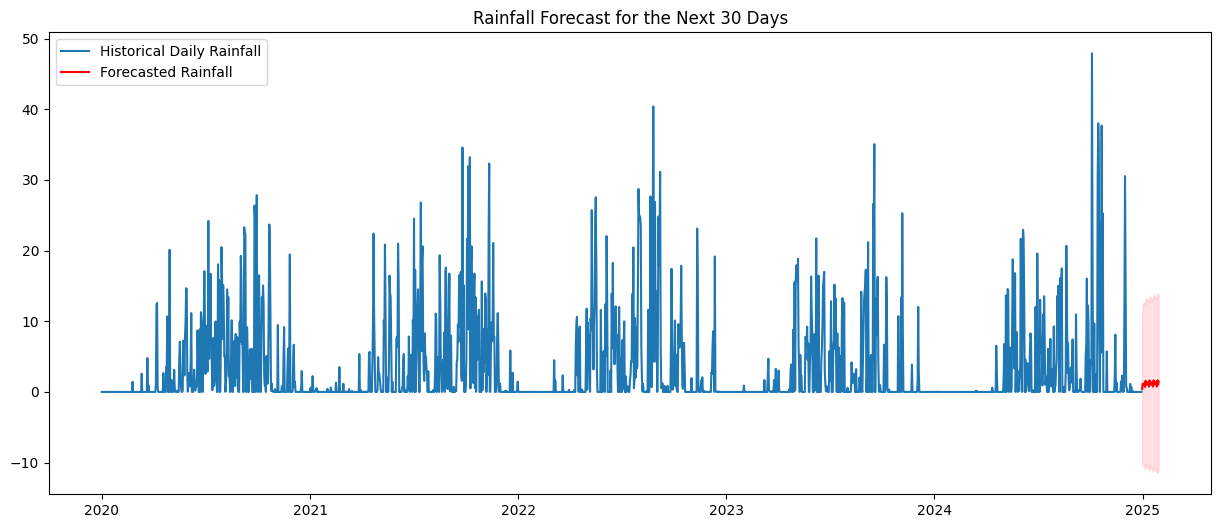

In [18]:
# --- Prepare data for time-series forecasting ---
avg_daily_rainfall = wards[date_columns].mean(axis=0)
avg_daily_rainfall.index = pd.to_datetime(avg_daily_rainfall.index)
ts_data = avg_daily_rainfall.asfreq('D')

# --- Train the SARIMA model ---
print("\nTraining SARIMA model to forecast rainfall...")
sarima_model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_results = sarima_model.fit(disp=False)
print("✅ SARIMA model trained.")

# --- Forecast rainfall for the next 30 days ---
forecast = sarima_results.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Plot the forecast ---
plt.figure(figsize=(15, 6))
plt.plot(ts_data, label='Historical Daily Rainfall')
plt.plot(forecast_mean, label='Forecasted Rainfall', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.title('Rainfall Forecast for the Next 30 Days')
plt.legend()
plt.show()

# Store forecasted values for the next step
forecasted_rainfall_values = forecast_mean.values

C:\Users\Harsh Singhal\AppData\Local\Temp\ipykernel_25032\2626918178.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wards['land_cover'].fillna(land_cover_mode, inplace=True)



RandomForest classification report:
              precision    recall  f1-score   support

   High Risk       0.85      0.69      0.76        16
    Low Risk       0.78      0.88      0.82        16
 Medium Risk       0.61      0.65      0.63        17

    accuracy                           0.73        49
   macro avg       0.75      0.74      0.74        49
weighted avg       0.74      0.73      0.73        49


GradientBoosting classification report:
              precision    recall  f1-score   support

   High Risk       0.80      0.75      0.77        16
    Low Risk       0.86      0.75      0.80        16
 Medium Risk       0.60      0.71      0.65        17

    accuracy                           0.73        49
   macro avg       0.75      0.74      0.74        49
weighted avg       0.75      0.73      0.74        49


LogisticRegression classification report:
              precision    recall  f1-score   support

   High Risk       1.00      0.94      0.97        16
    Low 

d:\Notes\Mini Proj\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Notes\Mini Proj\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


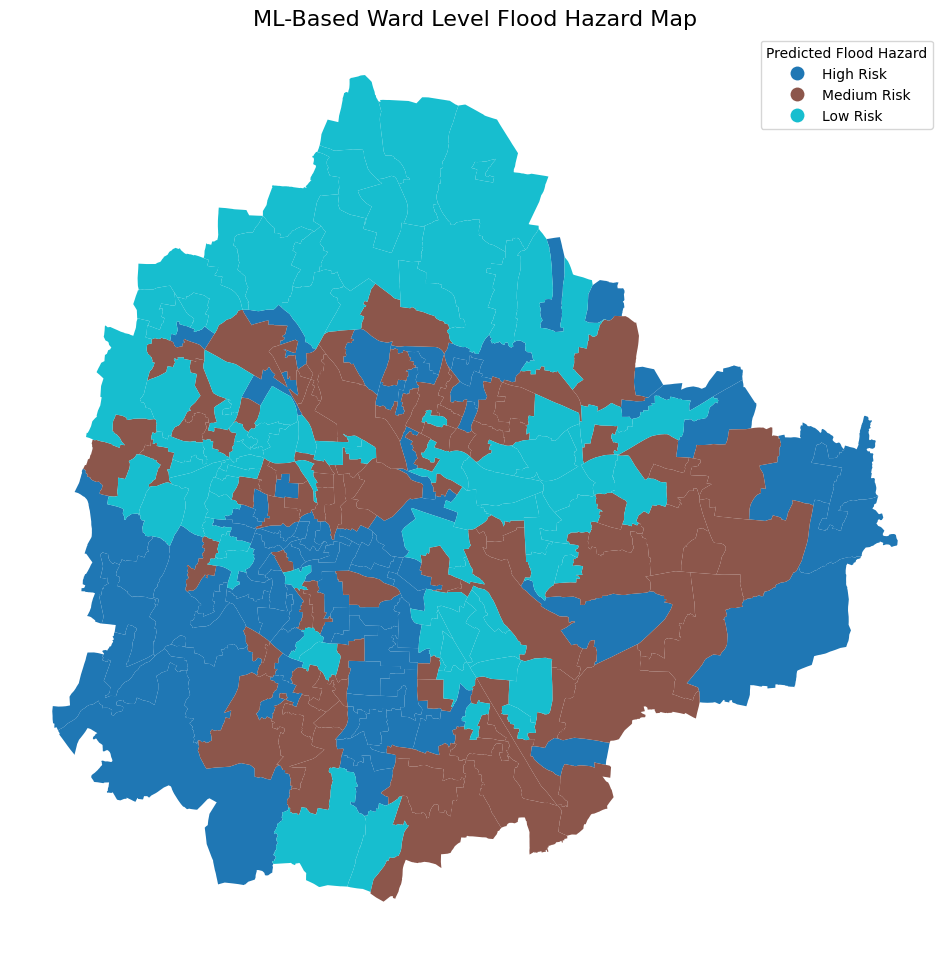

In [21]:
# --- Create Target Variable for ML Model ---
scaler = MinMaxScaler()
wards[['elevation_norm', 'slope_norm', 'rainfall_norm', 'drainage_norm']] = scaler.fit_transform(
    wards[['mean_elevation', 'mean_slope', 'average_rainfall', 'drainage_density']]
 )
wards['hazard_score'] = (1 - wards['elevation_norm']) + (1 - wards['slope_norm']) + wards['rainfall_norm'] + (1 - wards['drainage_norm'])
wards['hazard_class'] = pd.qcut(wards['hazard_score'], q=3, labels=['Low Risk', 'Medium Risk', 'High Risk'])

# --- Prepare data for model comparison ---
features = ['mean_elevation', 'mean_slope', 'average_rainfall', 'max_daily_rainfall', 'rainfall_std', 'total_rainfall', 'land_cover', 'drainage_density']
numeric_features = ['mean_elevation', 'mean_slope', 'average_rainfall', 'max_daily_rainfall', 'rainfall_std', 'total_rainfall', 'drainage_density']

wards[numeric_features] = wards[numeric_features].apply(pd.to_numeric, errors='coerce')
wards[numeric_features] = wards[numeric_features].fillna(wards[numeric_features].median())
if wards['land_cover'].isna().any():
    land_cover_mode = wards['land_cover'].mode().iloc[0]
    wards['land_cover'].fillna(land_cover_mode, inplace=True)

target = 'hazard_class'
X = wards[features]
y = wards[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
    'SupportVectorMachine': Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True, random_state=42))])
}

performance_records = []
fitted_models = {}

for name, clf in models.items():
    fitted = clf.fit(X_train, y_train)
    fitted_models[name] = fitted
    preds = fitted.predict(X_test)
    acc = accuracy_score(y_test, preds)
    performance_records.append({'model': name, 'accuracy': acc})
    print(f"\n{name} classification report:")
    print(classification_report(y_test, preds))

performance_df = pd.DataFrame(performance_records).sort_values('accuracy', ascending=False)
print("\nModel comparison (sorted by accuracy):")
print(performance_df.to_string(index=False))

best_model_name = performance_df.iloc[0]['model']
model = fitted_models[best_model_name]
print(f"\n✅ Selected best model: {best_model_name} with accuracy {performance_df.iloc[0]['accuracy']:.2%}")

# --- Evaluate the selected model ---
y_pred = model.predict(X_test)
print(f"\nBest model accuracy on test data: {accuracy_score(y_test, y_pred):.2%}")

# --- Generate predictions for all wards using the selected model ---
wards['predicted_hazard'] = model.predict(wards[features])
hazard_order = ['High Risk', 'Medium Risk', 'Low Risk']
wards['predicted_hazard'] = pd.Categorical(wards['predicted_hazard'], categories=hazard_order, ordered=True)
prioritized_wards = wards.sort_values(by='predicted_hazard')

print("\n--- Top 10 Wards for Infrastructure Prioritization (based on best ML model) ---")
print(prioritized_wards[[ward_display_column, 'predicted_hazard']].head(10).to_string())

# --- Visualize the final ML-based Hazard Map ---
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
prioritized_wards.plot(column='predicted_hazard',
                  ax=ax,
                  categorical=True,
                  legend=True,
                  legend_kwds={'title': "Predicted Flood Hazard"})
ax.set_title('ML-Based Ward Level Flood Hazard Map', fontdict={'fontsize': '16', 'fontweight': '3'})
plt.axis('off')
plt.show()


Confusion Matrix (rows=true, cols=predicted):
             High Risk  Medium Risk  Low Risk
High Risk           15            1         0
Medium Risk          0           15         2
Low Risk             0            2        14

Classification Report (selected model):
              precision    recall  f1-score   support

   High Risk       1.00      0.94      0.97        16
    Low Risk       0.88      0.88      0.88        16
 Medium Risk       0.83      0.88      0.86        17

    accuracy                           0.90        49
   macro avg       0.90      0.90      0.90        49
weighted avg       0.90      0.90      0.90        49


Macro ROC-AUC: 0.969


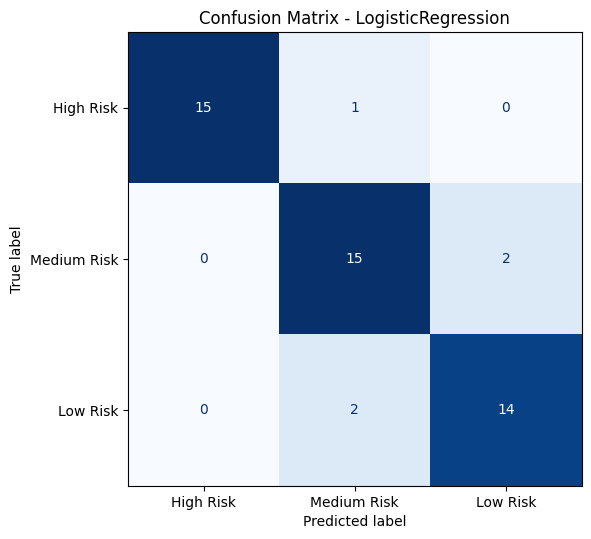

In [23]:
# --- Detailed evaluation diagnostics for the selected model ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np

best_preds = model.predict(X_test)
cm = confusion_matrix(y_test, best_preds, labels=hazard_order)

print("\nConfusion Matrix (rows=true, cols=predicted):")
print(pd.DataFrame(cm, index=hazard_order, columns=hazard_order))

print("\nClassification Report (selected model):")
print(classification_report(y_test, best_preds))

if hasattr(model, "predict_proba") and len(hazard_order) == 3:
    probas = model.predict_proba(X_test)
    try:
        roc_auc = roc_auc_score(y_test, probas, multi_class='ovr')
        print(f"\nMacro ROC-AUC: {roc_auc:.3f}")
    except ValueError:
        pass

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hazard_order)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()


--- Dynamic Risk Forecast for Ward: 217-Uttarahalli ---
Using best-performing model: LogisticRegression

Predicted Flood Hazard Over the Next 30 Days:
           predicted_hazard
2024-12-31         Low Risk
2025-01-01         Low Risk
2025-01-02         Low Risk
2025-01-03         Low Risk
2025-01-04         Low Risk
2025-01-05         Low Risk
2025-01-06         Low Risk
2025-01-07         Low Risk
2025-01-08         Low Risk
2025-01-09         Low Risk
2025-01-10         Low Risk
2025-01-11         Low Risk
2025-01-12         Low Risk
2025-01-13         Low Risk
2025-01-14         Low Risk
2025-01-15         Low Risk
2025-01-16         Low Risk
2025-01-17         Low Risk
2025-01-18         Low Risk
2025-01-19         Low Risk
2025-01-20         Low Risk
2025-01-21         Low Risk
2025-01-22         Low Risk
2025-01-23         Low Risk
2025-01-24         Low Risk
2025-01-25         Low Risk
2025-01-26         Low Risk
2025-01-27         Low Risk
2025-01-28         Low Risk
2025-01-

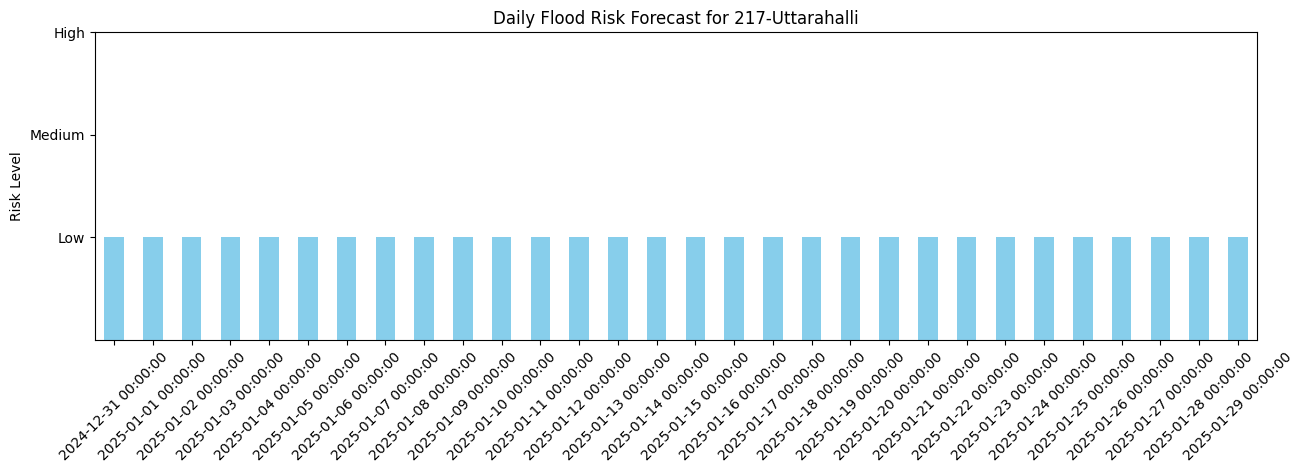

In [24]:
# --- Select a high-risk ward to analyze ---
high_risk_ward = wards.sort_values('hazard_score', ascending=False).iloc[0]
print(f"\n--- Dynamic Risk Forecast for Ward: {high_risk_ward[ward_display_column]} ---")
print(f"Using best-performing model: {best_model_name}")

# --- Create a forecast dataset for this ward ---
forecast_horizon = len(forecasted_rainfall_values)
base_feature_values = high_risk_ward[features].values
forecast_df = pd.DataFrame([base_feature_values] * forecast_horizon, columns=features)
forecast_df['average_rainfall'] = forecasted_rainfall_values
forecast_df['max_daily_rainfall'] = forecast_df[['max_daily_rainfall', 'average_rainfall']].max(axis=1)

# --- Predict the flood hazard for each of the forecasted days ---
dynamic_predictions = model.predict(forecast_df)
forecast_df['predicted_hazard'] = dynamic_predictions
forecast_df.index = forecast_mean.index

print("\nPredicted Flood Hazard Over the Next 30 Days:")
print(forecast_df[['predicted_hazard']].to_string())

# --- Visualize the dynamic risk ---
plt.figure(figsize=(15, 4))
risk_levels = {'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3}
forecast_df['predicted_hazard_level'] = forecast_df['predicted_hazard'].map(risk_levels)

forecast_df['predicted_hazard_level'].plot(kind='bar', color='skyblue')
plt.title(f'Daily Flood Risk Forecast for {high_risk_ward[ward_display_column]}')
plt.ylabel('Risk Level')
plt.xticks(rotation=45)
plt.yticks([1, 2, 3], ['Low', 'Medium', 'High'])
plt.show()

In [25]:
from pathlib import Path
import json
import joblib

# --- Export artefacts for the web application ---
output_dir = Path('webapp') / 'data'
output_dir.mkdir(parents=True, exist_ok=True)

essential_columns = [
    ward_calculation_id,
    ward_display_column,
    'hazard_score',
    'predicted_hazard',
    'average_rainfall',
    'max_daily_rainfall',
    'rainfall_std',
    'total_rainfall',
    'drainage_density',
    'mean_elevation',
    'mean_slope',
    'land_cover'
 ]
wards_export = wards[essential_columns + ['geometry']].copy()

# Ensure geometries are in WGS84 for web mapping
if wards_export.crs is None or wards_export.crs.to_epsg() != 4326:
    wards_export = wards_export.to_crs(4326)

wards_export.to_file(output_dir / 'wards_predictions.geojson', driver='GeoJSON')
performance_df.to_json(output_dir / 'model_comparison.json', orient='records', indent=2)

hazard_counts = (
    wards['predicted_hazard']
    .value_counts()
    .reindex(hazard_order)
    .fillna(0)
    .astype(int)
    .to_dict()
)
metrics = {
    'best_model': best_model_name,
    'accuracy': float(performance_df.iloc[0]['accuracy']),
    'hazard_order': list(hazard_order),
    'hazard_counts': hazard_counts,
    'generated_at': pd.Timestamp.utcnow().isoformat()
}
(output_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2))

joblib.dump(model, output_dir / 'model.pkl')

print(f"✅ Web artefacts saved to {output_dir.resolve()}")

✅ Web artefacts saved to D:\Notes\Mini Proj\webapp\data
